In [2]:
import scanpy as sc

# Load the AnnData object from the specified file path
adata_squidiff = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/results/fig2/figure2_diff_recon_1022.h5ad')

/tmp/ipykernel_645154/264063549.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_squidiff)


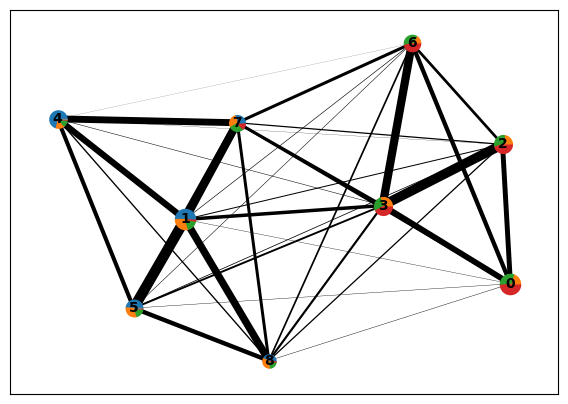

In [6]:
import numpy as np
sc.tl.pca(adata_squidiff, n_comps=50)  # Adjust number of components based on dataset size

# Step 2: Compute the neighborhood graph for connectivity
sc.pp.neighbors(adata_squidiff, n_neighbors=15, n_pcs=50)  # Adjust parameters as needed

sc.tl.leiden(adata_squidiff)
# Step 3: Run PAGA to identify clusters and abstract transitions
sc.tl.paga(adata_squidiff, groups='leiden')  # Replace 'leiden' with the column that stores cell clusters

# Optional: Plot the PAGA structure to inspect
sc.pl.paga(adata_squidiff, color='weights')  # Use your actual condition metadata column


adata_squidiff.uns['iroot'] = np.flatnonzero(adata_squidiff.obs['weights'] == '0')[0]

# Re-run DPT with an explicit root cell
sc.tl.dpt(adata_squidiff)

# Step 5: Save PAGA-inferred pseudotime to the AnnData object
adata_squidiff.obs['pseudotime_paga'] = adata_squidiff.obs['dpt_pseudotime']

In [7]:
adata_squidiff.obs[['dpt_pseudotime']].to_csv('figure2_dataset1_time_paga.csv')

In [8]:
adata_squidiff.obs

,weights,pseudotime_scorpius,pseudotime_monocle,leiden,dpt_pseudotime,pseudotime_paga
0,0,0.199662,3.806582,1,0.000000,0.000000
1,0,0.007775,0.266446,4,0.465827,0.465827
2,0,0.050001,0.379327,4,0.365567,0.365567
3,0,0.250584,4.031182,1,0.077570,0.077570
4,0,0.277003,3.806592,5,0.124399,0.124399
...,...,...,...,...,...,...
2395,3,0.923864,22.208143,0,0.478945,0.478945
2396,3,0.574470,24.609053,3,0.396383,0.396383
2397,3,0.665939,24.609063,2,0.443427,0.443427
2398,3,0.781507,24.574003,3,0.410236,0.410236


In [9]:
import pandas as pd
adata_squidiff.obs[['pseudotime_scorpius']] = pd.read_csv('figure2_dataset1_time_1022.csv',index_col=0).values

In [10]:
adata_squidiff.obs[['pseudotime_monocle']] = pd.read_csv('figure2_dataset1_time_monocle.csv',index_col=0).values

In [11]:
adata_squidiff.obs['pseudotime_random'] = np.random.rand(adata_squidiff.n_obs)

In [12]:
from scipy.stats import spearmanr

# Calculate correlation between random pseudotime and actual conditions
correlation_random = spearmanr(adata_squidiff.obs['pseudotime_random'], adata_squidiff.obs['weights'])[0]

# Correlations for each method and the random baseline
correlations = {
    'PAGA': spearmanr(adata_squidiff.obs['pseudotime_paga'], adata_squidiff.obs['weights'])[0],
    'Monocle': spearmanr(adata_squidiff.obs['pseudotime_monocle'], adata_squidiff.obs['weights'])[0],
    #'Slingshot': spearmanr(adata_squidiff.obs['pseudotime_slingshot'], adata_squidiff.obs['weights'])[0],
    'Scorpius': spearmanr(adata_squidiff.obs['pseudotime_scorpius'], adata_squidiff.obs['weights'])[0],
    'Random': correlation_random,
}

print("Correlation with Conditions including Random Baseline:", correlations)

Correlation with Conditions including Random Baseline: {'PAGA': 0.5088116175326155, 'Monocle': 0.7487843760663648, 'Scorpius': 0.6340806306996766, 'Random': 0.01604437281875862}


In [22]:
def extract_top_de_genes(rec_array, top_n=10):
    """
    Extracts the top N unique DE gene names from a Scanpy recarray.
    
    Parameters:
    - rec_array: A recarray or similar nested structure from Scanpy's DE analysis
    - top_n: Number of top DE genes to extract (default is 30)
    
    Returns:
    - A set of unique top N gene names
    """
    gene_list = []

    rec_array = pd.DataFrame(rec_array)
    #print(rec_array)
    # Iterate through the nested structure and collect gene names up to the top N
    for row in rec_array.iloc[:top_n,:].values:  # Only take the top N rows
        #print(row)
        gene_list.extend(row)  # Append all elements from the current row

    # Convert the list to a set to get unique gene names
    return set(gene_list)

# Extract the top 30 DE genes for each comparison

# Perform DE analysis using real-time conditions as the grouping factor
sc.tl.rank_genes_groups(adata_squidiff, groupby='weights', method='wilcoxon')
de_genes_real = extract_top_de_genes(adata_squidiff.uns['rank_genes_groups']['names'])

# Define pseudotime bins and perform DE analysis for PAGA
adata_squidiff.obs['paga_bins'] = pd.cut(adata_squidiff.obs['pseudotime_paga'], bins=4, labels=['Bin1', 'Bin2', 'Bin3', 'Bin4'])
sc.tl.rank_genes_groups(adata_squidiff, groupby='paga_bins', method='wilcoxon')
de_genes_paga = extract_top_de_genes(adata_squidiff.uns['rank_genes_groups']['names'])

# Define pseudotime bins and perform DE analysis for Monocle
adata_squidiff.obs['monocle_bins'] = pd.cut(adata_squidiff.obs['pseudotime_monocle'], bins=4, labels=['Bin1', 'Bin2', 'Bin3', 'Bin4'])
sc.tl.rank_genes_groups(adata_squidiff, groupby='monocle_bins', method='wilcoxon')
de_genes_monocle = extract_top_de_genes(adata_squidiff.uns['rank_genes_groups']['names'])

# Define pseudotime bins and perform DE analysis for Scorpius
adata_squidiff.obs['scorpius_bins'] = pd.cut(adata_squidiff.obs['pseudotime_scorpius'], bins=4, labels=['Bin1', 'Bin2', 'Bin3', 'Bin4'])
sc.tl.rank_genes_groups(adata_squidiff, groupby='scorpius_bins', method='wilcoxon')
de_genes_scorpius = extract_top_de_genes(adata_squidiff.uns['rank_genes_groups']['names'])

# (Optional) Add code for Slingshot if needed using a similar approach.
def jaccard_index(set1, set2):
    if not set1 or not set2:  # If either set is empty, return 0
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

# Calculate Jaccard Indices for comparison
jaccard_paga = jaccard_index(de_genes_real, de_genes_paga)
jaccard_monocle = jaccard_index(de_genes_real, de_genes_monocle)
jaccard_scorpius = jaccard_index(de_genes_real, de_genes_scorpius)

print(f"Jaccard Index with Real DE Genes - PAGA: {jaccard_paga:.2f}, Monocle: {jaccard_monocle:.2f}, Scorpius: {jaccard_scorpius:.2f}")


Jaccard Index with Real DE Genes - PAGA: 0.38, Monocle: 0.51, Scorpius: 0.38


/tmp/ipykernel_645154/1058686893.py:14: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return set(random.sample(gene_pool, top_n))
/tmp/ipykernel_645154/1058686893.py:14: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return set(random.sample(gene_pool, top_n))
/tmp/ipykernel_645154/1058686893.py:14: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return set(random.sample(gene_pool, top_n))
/tmp/ipykernel_645154/1058686893.py:14: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return set(random.sample(gene_pool, top_n))
/tmp/ipykernel_645154/1058686893.py:14: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return set(random.sample(gene_pool, top_n))
/tmp/

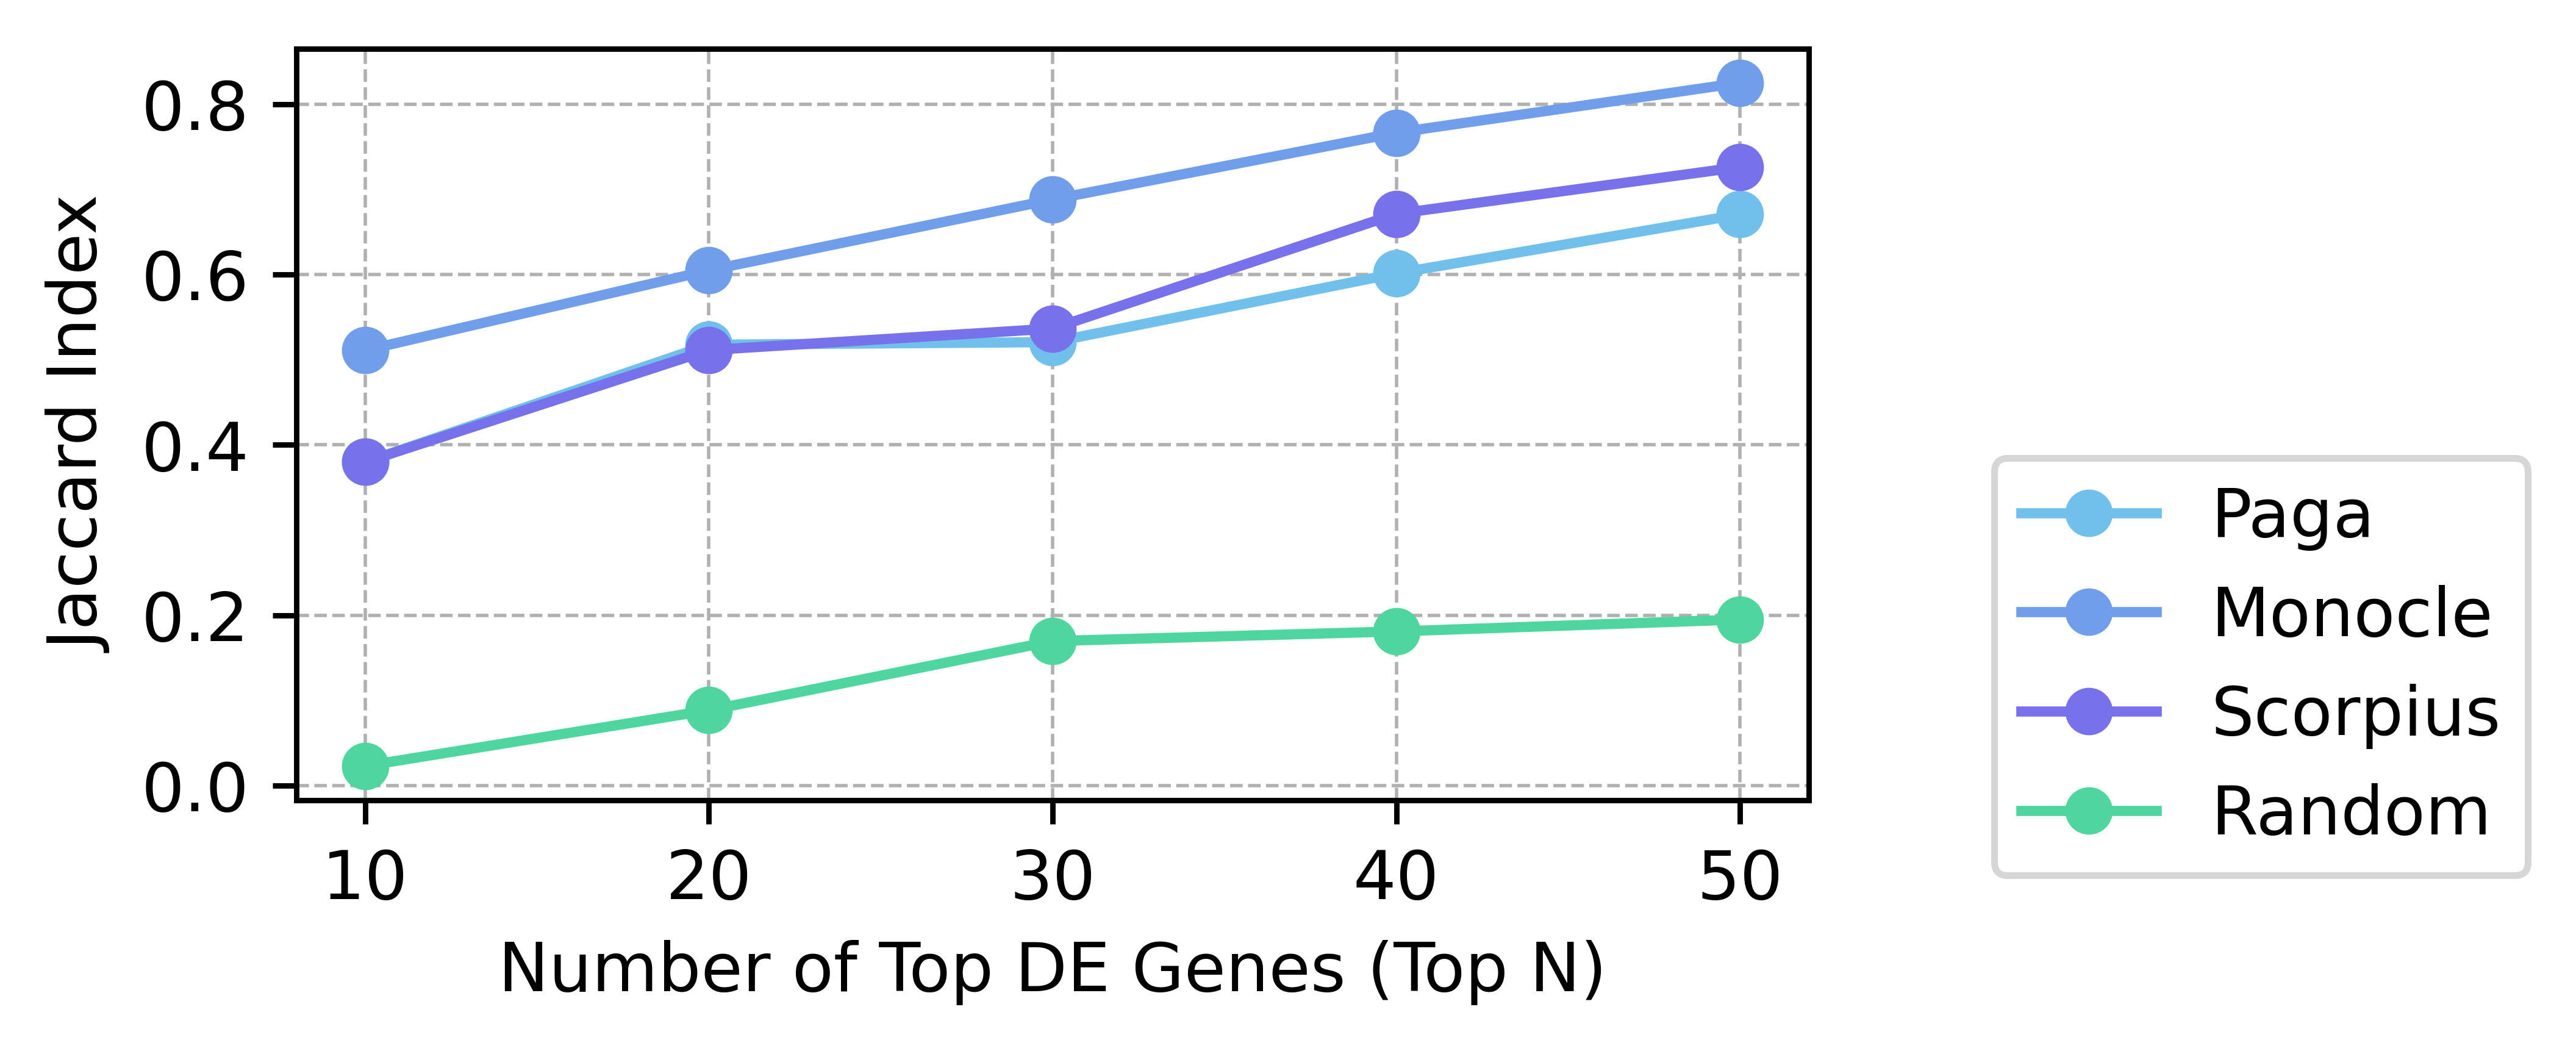

In [23]:
import random

def generate_random_de_genes(gene_pool, top_n=10):
    """
    Generates a random set of DE genes from a given gene pool.
    
    Parameters:
    - gene_pool: A list or set of all possible gene names.
    - top_n: The number of random DE genes to select.
    
    Returns:
    - A set of randomly selected gene names.
    """
    return set(random.sample(gene_pool, top_n))

def compute_jaccard_with_random_baseline(adata, top_ns, groupby_columns):
    jaccard_scores = {method: [] for method in groupby_columns}
    jaccard_scores['random'] = []  # Add entry for the random baseline
    
    # Get the pool of all gene names to use for generating random DE genes
    all_genes = set(adata.var_names)  # Assuming gene names are stored in var_names

    for top_n in top_ns:
        # Extract DE genes for real-time conditions using the current top_n value
        sc.tl.rank_genes_groups(adata, groupby='weights', method='wilcoxon')
        de_genes_real = extract_top_de_genes(adata.uns['rank_genes_groups']['names'], top_n=top_n)

        # Iterate through the methods and calculate Jaccard Index for each
        for method in groupby_columns:
            # Define pseudotime bins and perform DE analysis for each method
            adata.obs[f'{method}_bins'] = pd.cut(adata.obs[f'pseudotime_{method}'], bins=4, labels=['Bin1', 'Bin2', 'Bin3', 'Bin4'])
            sc.tl.rank_genes_groups(adata, groupby=f'{method}_bins', method='wilcoxon')
            
            # Extract DE genes for the current method using top_n
            de_genes_method = extract_top_de_genes(adata.uns['rank_genes_groups']['names'], top_n=top_n)
            
            # Calculate and store the Jaccard Index
            jaccard = jaccard_index(de_genes_real, de_genes_method)
            jaccard_scores[method].append(jaccard)
        
        # Generate a random DE gene set and calculate its Jaccard Index
        random_de_genes = generate_random_de_genes(all_genes, top_n=top_n)
        jaccard_random = jaccard_index(de_genes_real, random_de_genes)
        jaccard_scores['random'].append(jaccard_random)
    
    return jaccard_scores

def extract_top_de_genes(rec_array, top_n=10):
    """
    Extracts the top N unique DE gene names from a Scanpy recarray.
    
    Parameters:
    - rec_array: A recarray or similar nested structure from Scanpy's DE analysis
    - top_n: Number of top DE genes to extract (default is 30)
    
    Returns:
    - A set of unique top N gene names
    """
    gene_list = []
    
    rec_array = pd.DataFrame(rec_array)
    
    # Iterate through the nested structure and collect gene names up to the top N
    for row in rec_array.iloc[:top_n, :].values:  # Only take the top N rows
        gene_list.extend(row)  # Append all elements from the current row

    # Convert the list to a set to get unique gene names
    return set(gene_list)

def jaccard_index(set1, set2):
    if not set1 or not set2:  # If either set is empty, return 0
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

# Define a function to compute Jaccard scores for multiple top_n values
def compute_jaccard_for_top_n(adata, top_ns, groupby_columns):
    jaccard_scores = {method: [] for method in groupby_columns}
    
    for top_n in top_ns:
        # Extract DE genes for real-time conditions using the current top_n value
        sc.tl.rank_genes_groups(adata, groupby='weights', method='wilcoxon')
        de_genes_real = extract_top_de_genes(adata.uns['rank_genes_groups']['names'], top_n=top_n)

        # Iterate through the methods and calculate Jaccard Index for each
        for method in groupby_columns:
            # Define pseudotime bins and perform DE analysis for each method
            adata.obs[f'{method}_bins'] = pd.cut(adata.obs[f'pseudotime_{method}'], bins=4, labels=['Bin1', 'Bin2', 'Bin3', 'Bin4'])
            sc.tl.rank_genes_groups(adata, groupby=f'{method}_bins', method='wilcoxon')
            
            # Extract DE genes for the current method using top_n
            de_genes_method = extract_top_de_genes(adata.uns['rank_genes_groups']['names'], top_n=top_n)
            
            # Calculate and store the Jaccard Index
            jaccard = jaccard_index(de_genes_real, de_genes_method)
            jaccard_scores[method].append(jaccard)
    
    return jaccard_scores

import matplotlib.pyplot as plt

def plot_jaccard_results(jaccard_scores, top_ns, methods):
    """
    Plots the Jaccard Index results for different top_n values across methods.
    
    Parameters:
    - jaccard_scores: A dictionary with methods as keys and lists of Jaccard indices as values.
    - top_ns: A list of top_n values that were tested.
    - methods: A list of methods that were compared.
    """
    plt.figure(figsize=(10, 6))
    
    for method in methods:
        plt.plot(top_ns, jaccard_scores[method], marker='o', label=method.capitalize())
    
    plt.title('Jaccard Index Comparison Across Methods and Top DE Genes')
    plt.xlabel('Number of Top DE Genes (Top N)')
    plt.ylabel('Jaccard Index with Real DE Genes')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

def plot_jaccard_results_with_baseline(jaccard_scores, top_ns, methods):
    """
    Plots the Jaccard Index results for different top_n values across methods, including a random baseline.
    
    Parameters:
    - jaccard_scores: A dictionary with methods as keys and lists of Jaccard indices as values.
    - top_ns: A list of top_n values that were tested.
    - methods: A list of methods that were compared.
    """
    plt.figure(figsize=(4, 2),dpi=800)
    color_list = ['#71c0eb', '#719eeb', '#7771eb', '#4fd69e', ]
    for (i,method) in enumerate(methods + ['random']):  # Include the random baseline in the plot
        plt.plot(top_ns, jaccard_scores[method], marker='o', 
                 label=method.capitalize(),
                 c = color_list[i]
                )
    
    #plt.title('Jaccard Index Comparison Across Methods and Top DE Genes (Including Random Baseline)')
    plt.xlabel('Number of Top DE Genes (Top N)')
    plt.ylabel('Jaccard Index')
    plt.grid(False, which='both', linestyle='--', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.1,0.5))
    plt.show()

# Define the top_n values to test and the pseudotime methods to compare
top_ns = [10, 20, 30, 40, 50]
methods = ['paga', 'monocle', 'scorpius']  # Add 'slingshot' if needed

# Compute Jaccard scores for each method at different top_n values, including random baseline
jaccard_scores = compute_jaccard_with_random_baseline(adata_squidiff, top_ns, methods)

# Plot the results with the random baseline
plot_jaccard_results_with_baseline(jaccard_scores, top_ns, methods)


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/preprocessing/_utils.py:29: RuntimeWarning: Mean of empty slice.
  return X.mean(axis=axis, dtype=dtype)
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:352: RuntimeWarning: divide b

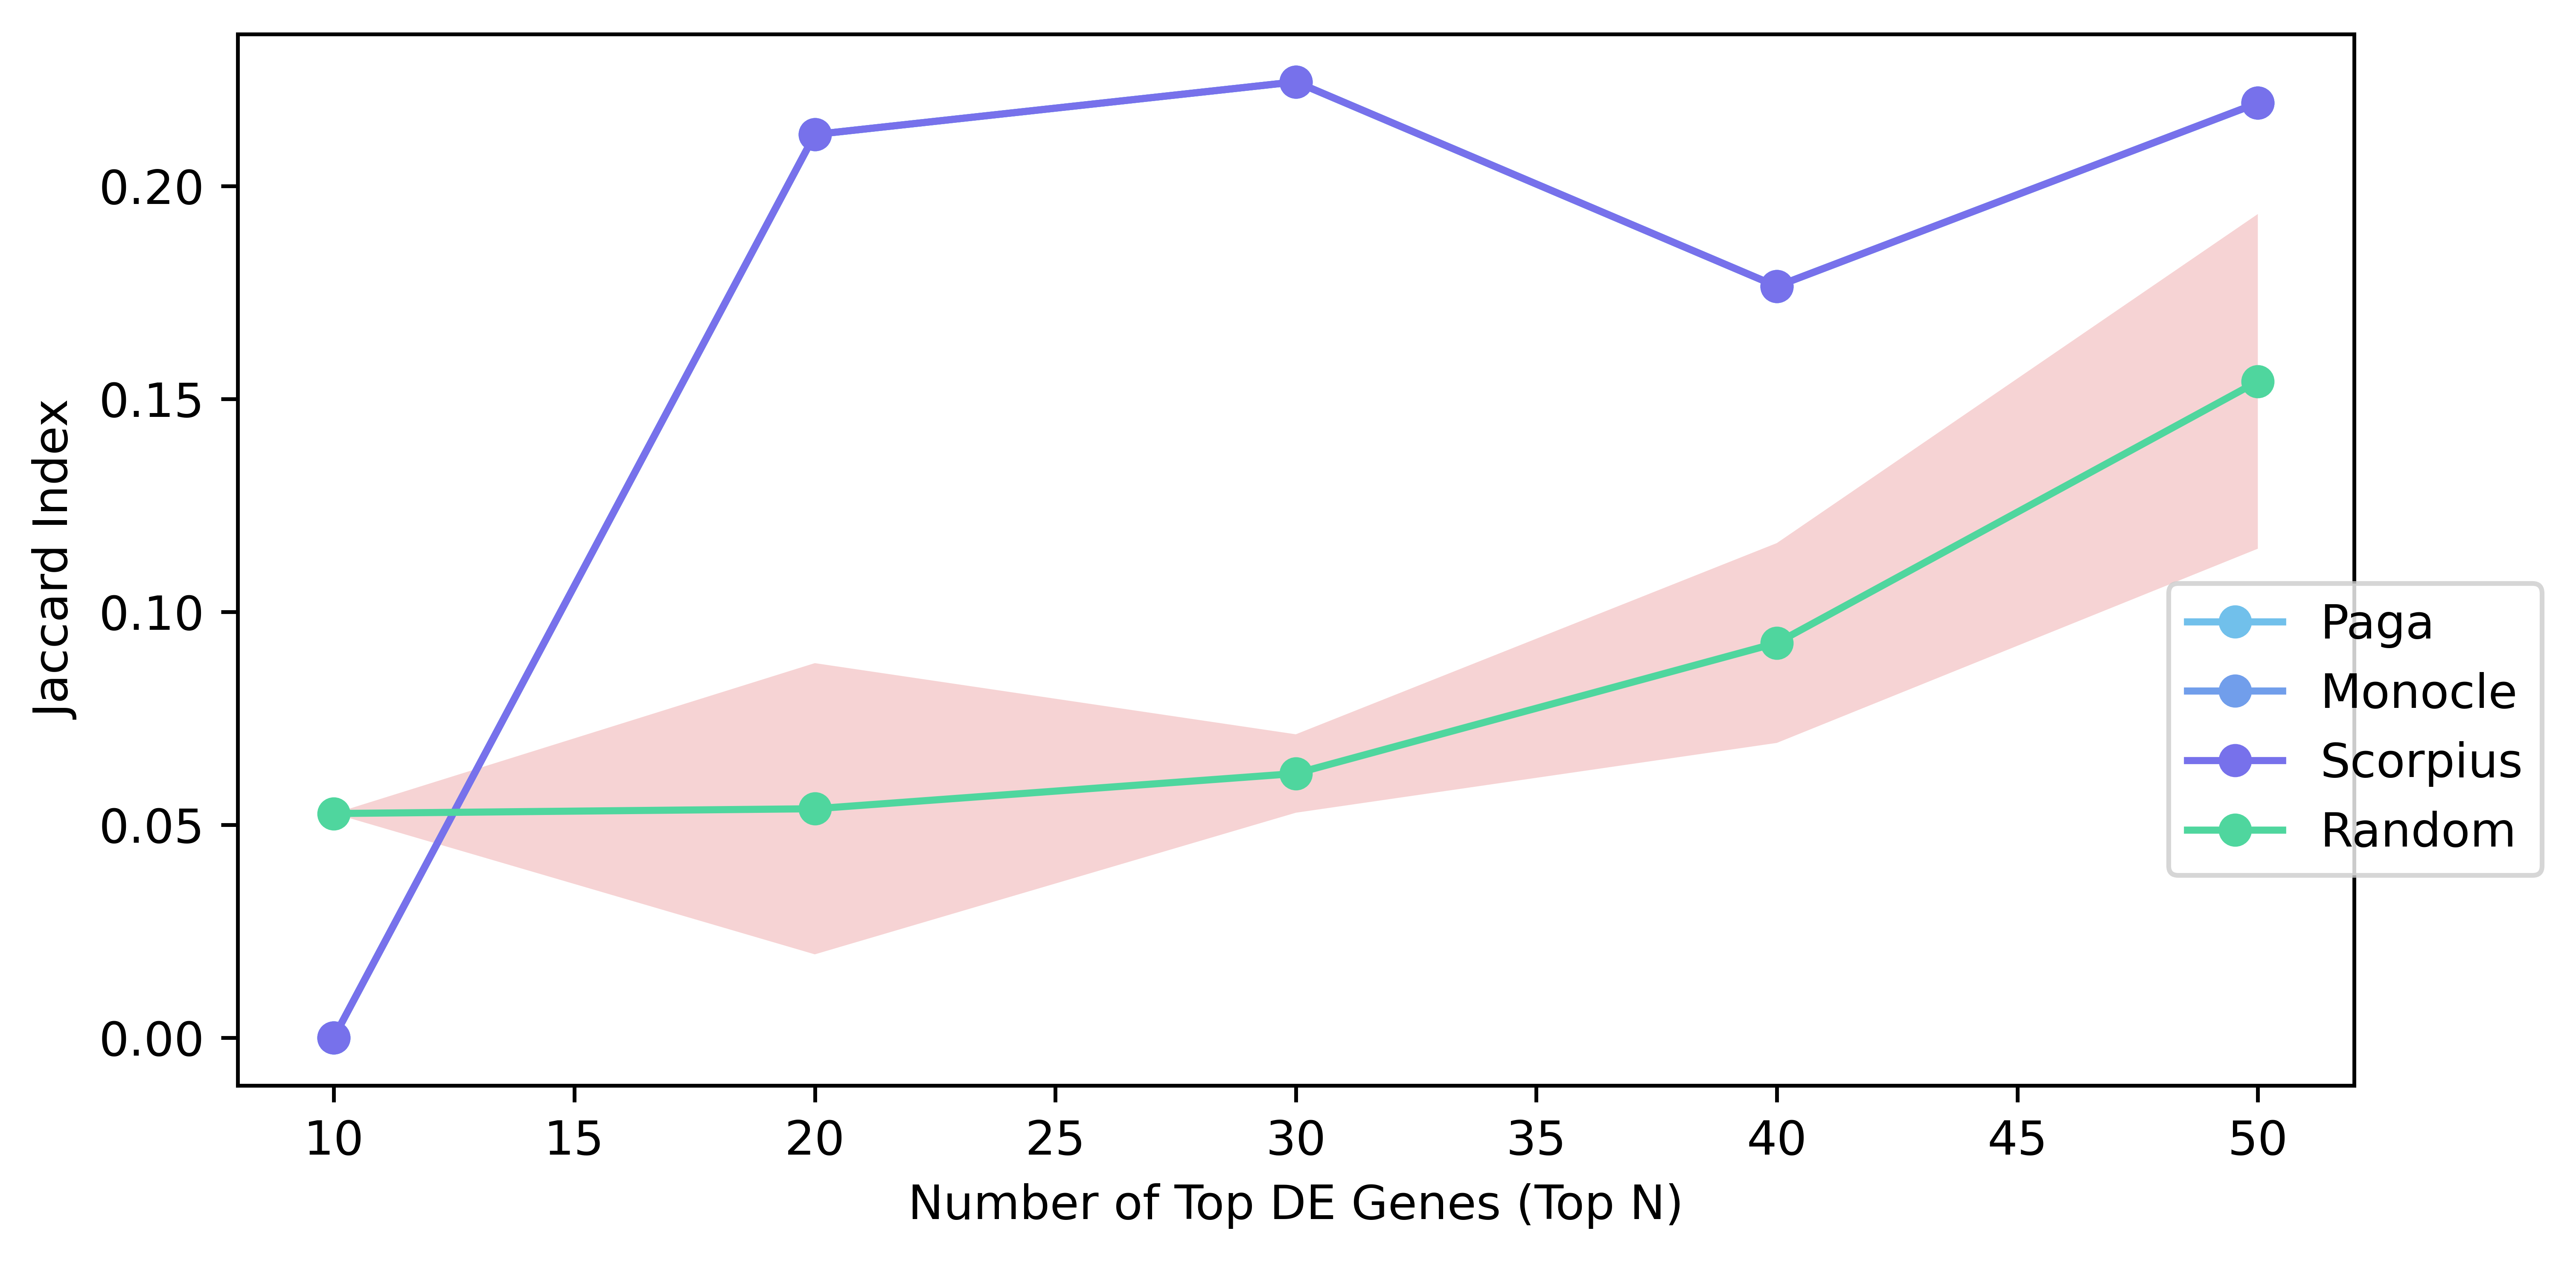

In [24]:
import random
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

def generate_random_de_genes(gene_pool, top_n=10):
    """
    Generates a random set of DE genes from a given gene pool.
    """
    return set(random.sample(gene_pool, top_n))

def compute_jaccard_with_random_baseline(adata, top_ns, groupby_columns):
    """
    Computes Jaccard scores for each method at multiple top_n values, including a random baseline.
    """
    jaccard_scores = {method: [] for method in groupby_columns}
    jaccard_scores['random'] = []  # Include a random baseline

    all_genes = set(adata.var_names)  # Assuming gene names are in var_names

    for top_n in top_ns:
        # Perform DE analysis for real-time conditions and get top DE genes
        sc.tl.rank_genes_groups(adata, groupby='weights', method='wilcoxon')
        de_genes_real = extract_top_de_genes(adata.uns['rank_genes_groups']['names'], top_n=top_n)

        for method in groupby_columns:
            # Define bins and perform DE analysis for each method
            bin_jaccards = []
            adata.obs[f'{method}_bins'] = pd.cut(adata.obs[f'pseudotime_{method}'], bins=4, labels=['Bin1', 'Bin2', 'Bin3', 'Bin4'])
            
            for bin_label in adata.obs[f'{method}_bins'].cat.categories:
                # Filter data by bin and perform DE analysis
                bin_adata = adata[adata.obs[f'{method}_bins'] == bin_label]
                sc.tl.rank_genes_groups(bin_adata, groupby=f'{method}_bins', method='wilcoxon')
                
                # Extract top DE genes for each bin
                de_genes_method = extract_top_de_genes(bin_adata.uns['rank_genes_groups']['names'], top_n=top_n)
                
                # Calculate Jaccard Index for each bin
                bin_jaccard_scores = [jaccard_index(real_genes, method_genes) for real_genes, method_genes in zip(de_genes_real, de_genes_method)]
                bin_jaccards.append(np.mean(bin_jaccard_scores))
            
            # Store mean and standard error for the method
            jaccard_scores[method].append({
                'mean': np.mean(bin_jaccards),
                'stderr': np.std(bin_jaccards) / np.sqrt(len(bin_jaccards))
            })
        
        # Random baseline calculation
        random_de_genes = [generate_random_de_genes(all_genes, top_n=top_n) for _ in de_genes_real]
        jaccard_random_scores = [jaccard_index(real_genes, random_genes) for real_genes, random_genes in zip(de_genes_real, random_de_genes)]
        
        jaccard_scores['random'].append({
            'mean': np.mean(jaccard_random_scores),
            'stderr': np.std(jaccard_random_scores) / np.sqrt(len(jaccard_random_scores))
        })
    
    return jaccard_scores

def extract_top_de_genes(rec_array, top_n=10):
    """
    Extracts the top N DE genes for each group separately.
    """
    gene_sets = []
    rec_array = pd.DataFrame(rec_array)
    
    for col in rec_array.columns:
        top_genes = set(rec_array[col].iloc[:top_n])
        gene_sets.append(top_genes)
    
    return gene_sets

def jaccard_index(set1, set2):
    """
    Computes the Jaccard Index between two sets.
    """
    if not set1 or not set2:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def plot_jaccard_results_with_baseline(jaccard_scores, top_ns, methods):
    """
    Plots Jaccard Index results for different top_n values across methods, including a random baseline.
    """
    plt.figure(figsize=(8, 4), dpi=800)
    color_list = ['#71c0eb', '#719eeb', '#7771eb', '#4fd69e']

    for i, method in enumerate(methods + ['random']):
        means = [jaccard_scores[method][j]['mean'] for j in range(len(top_ns))]
        stderrs = [jaccard_scores[method][j]['stderr'] for j in range(len(top_ns))]

        plt.plot(top_ns, means, marker='o', label=method.capitalize(), color=color_list[i])
        plt.fill_between(top_ns,
                         [m - 1.96 * s for m, s in zip(means, stderrs)],
                         [m + 1.96 * s for m, s in zip(means, stderrs)],
                         alpha=0.2)

    plt.xlabel('Number of Top DE Genes (Top N)')
    plt.ylabel('Jaccard Index')
    plt.legend(bbox_to_anchor=(1.1, 0.5))
    plt.grid(False)
    plt.show()

# Define the parameters
top_ns = [10, 20, 30, 40, 50]
methods = ['paga', 'monocle', 'scorpius']  # Add more methods if needed

# Compute Jaccard scores for each method at different top_n values, including random baseline
jaccard_scores = compute_jaccard_with_random_baseline(adata_squidiff, top_ns, methods)

# Plot the results with the random baseline and confidence intervals
plot_jaccard_results_with_baseline(jaccard_scores, top_ns, methods)


In [25]:
jaccard_scores

{'paga': [{'mean': 0.0, 'stderr': 0.0},
  {'mean': 0.21212121212121213, 'stderr': 0.0},
  {'mean': 0.22448979591836735, 'stderr': 0.0},
  {'mean': 0.17647058823529413, 'stderr': 0.0},
  {'mean': 0.21951219512195122, 'stderr': 0.0}],
 'monocle': [{'mean': 0.0, 'stderr': 0.0},
  {'mean': 0.21212121212121213, 'stderr': 0.0},
  {'mean': 0.22448979591836735, 'stderr': 0.0},
  {'mean': 0.17647058823529413, 'stderr': 0.0},
  {'mean': 0.21951219512195122, 'stderr': 0.0}],
 'scorpius': [{'mean': 0.0, 'stderr': 0.0},
  {'mean': 0.21212121212121213, 'stderr': 0.0},
  {'mean': 0.22448979591836735, 'stderr': 0.0},
  {'mean': 0.17647058823529413, 'stderr': 0.0},
  {'mean': 0.21951219512195122, 'stderr': 0.0}],
 'random': [{'mean': 0.05263157894736842, 'stderr': 0.0},
  {'mean': 0.0537561853351327, 'stderr': 0.017449528395392374},
  {'mean': 0.06203007518796992, 'stderr': 0.004699248120300752},
  {'mean': 0.09268605303212368, 'stderr': 0.011972871247004024},
  {'mean': 0.15413865015211578, 'stderr': 